In [36]:
using JuMP, Gurobi, PyPlot, Images, FileIO

## Functions

In [37]:
# input: array with all the given dots (each number represents the colours) and number of colours
# output: solved flows problem
function find_answer(array)
    
    m = Model(solver=GurobiSolver(OutputFlag=0))
    xsize, ysize = size(array)
    n = Int8(findmax(array)[1])
    
    # variable to control the colours of each blocks (and constraints)
    @variable(m, ans[0:xsize+1,0:ysize+1,1:n], Bin)
    @constraint(m, [i=0:xsize+1,k=1:n], ans[i,0,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], ans[i,ysize+1,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], ans[0,j,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], ans[xsize+1,j,k] == 0)
    
    # only one colour in each square
    @constraint(m, [i=1:xsize, j=1:ysize], sum(ans[i,j,:]) == 1)
    
    # variable for edges between each nodes (one variable for edge between two points and which colour)
    @variable(m, hedges[0:xsize,0:ysize+1,1:n], Bin)
    @variable(m, vedges[0:xsize+1,0:ysize,1:n], Bin)
    @constraint(m, [j=0:ysize+1,k=1:n], hedges[0,j,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], hedges[xsize,j,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], vedges[i,0,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], vedges[i,ysize,k] == 0)
    
    # each edges can only be there if colours are the same
    @constraint(m, [i=0:xsize,j=0:ysize+1,k=1:n], ans[i,j,k] + ans[i+1,j,k] >= 2*hedges[i,j,k])
    @constraint(m, [i=0:xsize+1,j=0:ysize,k=1:n], ans[i,j,k] + ans[i,j+1,k] >= 2*vedges[i,j,k])
    
    # at most one of the edges is filled for each colour
    @constraint(m, [i=1:xsize-1,j=1:ysize], sum(hedges[i,j,:]) <= 1)
    @constraint(m, [i=1:xsize,j=1:ysize-1], sum(vedges[i,j,:]) <= 1)
    
    # fix the given points in place
    # and fix the number of edges through each of the points
    for i in 1:xsize
        for j in 1:ysize
            if array[i,j] != 0
                co = array[i,j]
                @constraint(m, ans[i,j,co] == 1)
                @constraint(m, hedges[i-1,j,co] + hedges[i,j,co] + vedges[i,j-1,co] + vedges[i,j,co] == 1)
            else
                @constraint(m, [k=1:n], hedges[i-1,j,k]+hedges[i,j,k]+vedges[i,j-1,k]+vedges[i,j,k] == 2*ans[i,j,k])
            end
        end
    end
    
    @objective(m, Max, sum(ans))
    solve(m)
    
    ans_array = getvalue(ans)
    final_answer = zeros(Int8, xsize, ysize)
    for x in 1:xsize
        for y in 1:ysize
            for c in 1:n
                if ans_array[x,y,c] == 1
                    final_answer[x,y] = c
                end
            end
        end
    end
    
    return final_answer
    
end

find_answer (generic function with 1 method)

In [3]:
function detect_board(img,thr=0.1)
    
    grad_y, grad_x, mag, orient = imedge(img)
    sy, sx = size(img)
    
    edges_mat = Array(channelview(mag));
    
    # randomly scan one of the columns, and find where the edges are
    # the boundaries should have edges at a constant place each time, so select those places
    # scan a couple of times
    row_loop = 0
    rows = Set(1:sy)
    while row_loop < 5
        
        test_col = rand(floor(Int,sx*0.2):floor(Int,sx*0.8))
        # if overall edge magnitude here too high then we know that we are on top of a line, so change sample
        if mean(edges_mat[:,test_col]) >= 0.2
            continue
        end
        
        pot_rows = []
        rising = false
        for i in 1:sy
            if edges_mat[i,test_col] > thr && !rising && ((length(pot_rows) == 0) || (i - last(pot_rows) > 4))
                push!(pot_rows,i)
                rising = true
            elseif edges_mat[i,test_col] <= thr && rising
                rising = false
            end
        end
        rows = intersect(rows,pot_rows)
        
        row_loop += 1
    end
    rows = sort(collect(rows))
    
    # detect the position of columns given we know the rows
    cols = Set(1:sx)
    for i in 1:length(rows)-1
        test_row = floor(Int, (rows[i] + rows[i+1])/2)
        pot_cols = []
        rising = false
        for i in 1:sx
            if edges_mat[test_row,i] > thr && !rising && ((length(pot_cols) == 0) || (i - last(pot_cols) > 4))
                push!(pot_cols,i)
                rising = true
            elseif edges_mat[test_row,i] <= thr && rising
                rising = false
            end
        end
        cols = intersect(cols,pot_cols)
    end
    cols = sort(collect(cols))
    
    return rows, cols
    
end

detect_board (generic function with 2 methods)

In [67]:
# Input: two colours in XYZ (closely related to human perception colours)
# Output: similarity index for colours
function colour_similar(c1, c2, thr=0.05)
    return sqrt((c1.x - c2.x)^2 + (c1.y - c2.y)^2 + (c1.z - c2.z)^2) < 0.05
end

# Input: image and colour similar threshold (arbitrary)
# Output: array of the problem, colours of each pair of starting points, and size of problem
function get_problem(img)
    
    rows, cols = detect_board(img)
    xsize = length(rows)-1
    ysize = length(cols)-1
    problem = zeros(Int, (xsize,ysize))
    colours = []
    colour_count = 0
    
    for x in 1:xsize
        for y in 1:ysize
            xco = floor(Int, (rows[x] + rows[x+1])/2)
            yco = floor(Int, (cols[y] + cols[y+1])/2)
            c = img[xco,yco]
            if convert(HSV,c).v > 0.2  # not part of black background
                c = convert(XYZ,c)
                new_colour = true
                for i in 1:colour_count
                    if colour_similar(c, colours[i])
                        new_colour = false
                        problem[x,y] = i
                    end
                end
                if new_colour
                    push!(colours, c)
                    colour_count += 1
                    problem[x,y] = colour_count
                end
            end
        end
    end
    
    convert(Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},1},colours)
    
    return problem, colours, rows, cols
    
end

get_problem (generic function with 1 method)

In [45]:
function draw_solution(img, img_filename, rows, cols, answer, colours)
    
    imgplot = imshow(imread(img_filename))
    thickness = (size(img)[2]) * 0.07 / (length(cols)-1)
    
    xcos = [floor(Int, (rows[i+1] + rows[i])/2) for i in 1:length(rows)-1]
    ycos = [floor(Int, (cols[i+1] + cols[i])/2) for i in 1:length(cols)-1]
    
    for x in 1:length(xcos)
        for y in 1:length(ycos)
            if (x+1 <= length(xcos)) && (answer[x,y] == answer[x+1,y])
                c = convert(RGB, colours[answer[x,y]])
                plot([ycos[y],ycos[y]],[xcos[x],xcos[x+1]],linewidth=thickness,color=(c.r,c.g,c.b))
            end
            if (y+1 <= length(ycos)) && answer[x,y] == answer[x,y+1]
                c = convert(RGB, colours[answer[x,y]])
                plot([ycos[y],ycos[y+1]],[xcos[x],xcos[x]],linewidth=thickness,color=(c.r,c.g,c.b))
            end
        end
    end
end

draw_solution (generic function with 1 method)

In [6]:
# Input: filename
# Output: the solution
function flows_solver(img_filename)
    
    img = load(img_filename)
    
    prob, colours, rows, cols = get_problem(img)
    
    ans = find_answer(prob)
    
    draw_solution(img, img_filename, rows, cols, ans, colours)
    
    return ans
    
end

flows_solver (generic function with 1 method)

## Demo

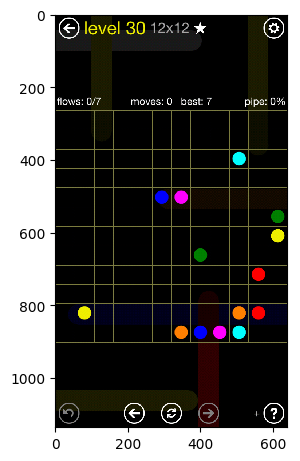

PyObject <matplotlib.image.AxesImage object at 0x17ec2abd0>

In [47]:
img_filename = "test5.png"
figure(figsize=(3,6))
imshow(imread(img_filename), interpolation="nearest")

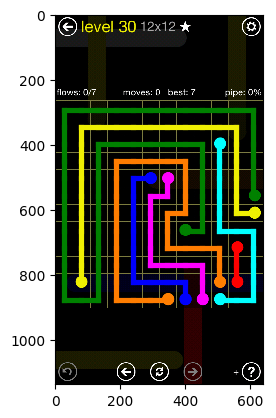

Academic license - for non-commercial use only
 40.342504 seconds (129.95 k allocations: 121.321 MiB, 0.62% gc time)


12×12 Array{Int8,2}:
 4  4  4  4  4  4  4  4  4  4  4  4
 4  5  5  5  5  5  5  5  5  5  5  4
 4  5  4  4  4  4  4  4  4  1  5  4
 4  5  4  7  7  7  7  7  4  1  5  4
 4  5  4  7  2  2  3  7  4  1  5  4
 4  5  4  7  2  3  3  7  4  1  5  4
 4  5  4  7  2  3  7  7  4  1  5  5
 4  5  4  7  2  3  7  4  4  1  1  1
 4  5  4  7  2  3  7  7  7  7  6  1
 4  5  4  7  2  3  3  3  3  7  6  1
 4  5  4  7  2  2  2  2  3  7  6  1
 4  4  4  7  7  7  7  2  3  1  1  1

In [48]:
@time flows_solver(img_filename)

## Scratch Work

super messy stuff down here

In [4]:
test_array = [1 0 0 0;
              2 0 0 1;
              4 4 2 3;
              3 0 0 0]

4×4 Array{Int64,2}:
 1  0  0  0
 2  0  0  1
 4  4  2  3
 3  0  0  0

In [5]:
find_answer(test_array)

Academic license - for non-commercial use only


4×4 Array{Int8,2}:
 1  1  1  1
 2  2  2  1
 4  4  2  3
 3  3  3  3

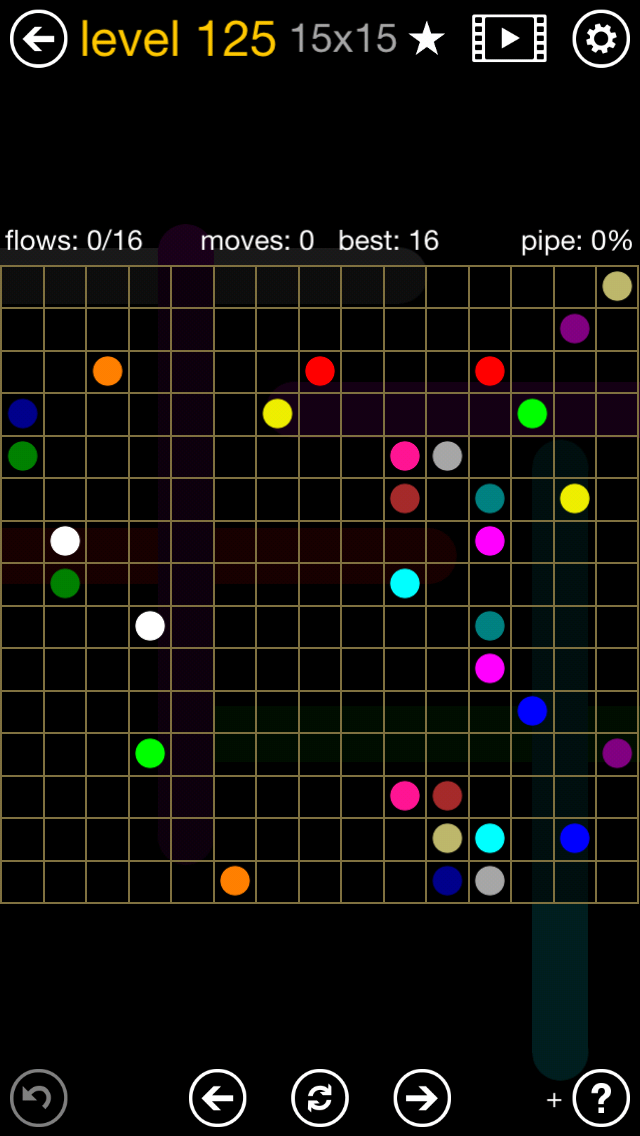

In [71]:
img = load("test3.png")

In [72]:
grad_y, grad_x, mag, orient = imedge(img);

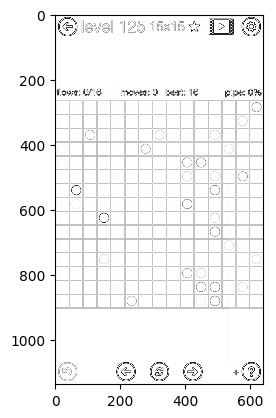

PyObject <matplotlib.image.AxesImage object at 0x13f6bf550>

In [73]:
imshow(mag,"Greys")

In [74]:
edges = grad_y + grad_x;

In [75]:
edges_mat = Array(channelview(mag));

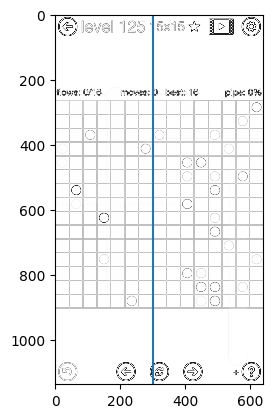

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1b99bc310>

In [85]:
imshow(edges_mat, "Greys")
k = 300
plot([k,k],[0,1135])

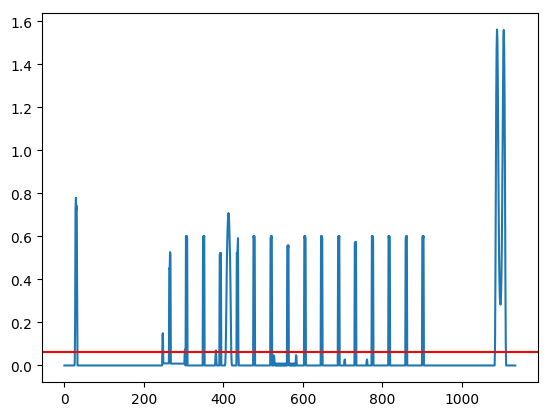

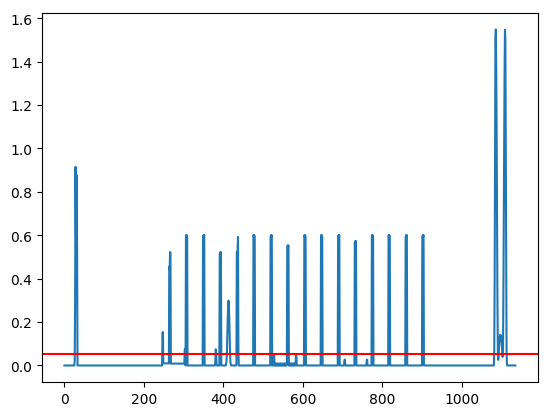

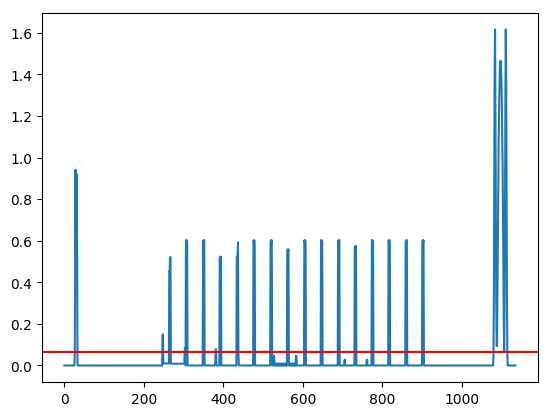

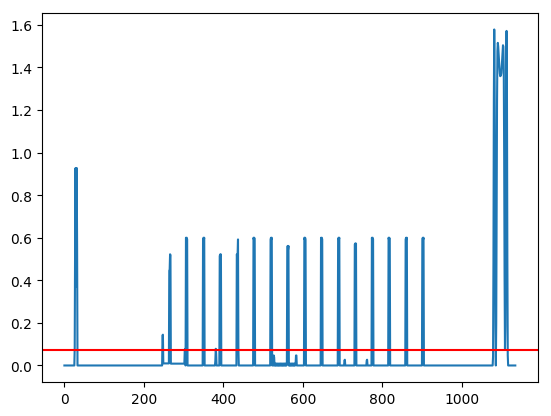

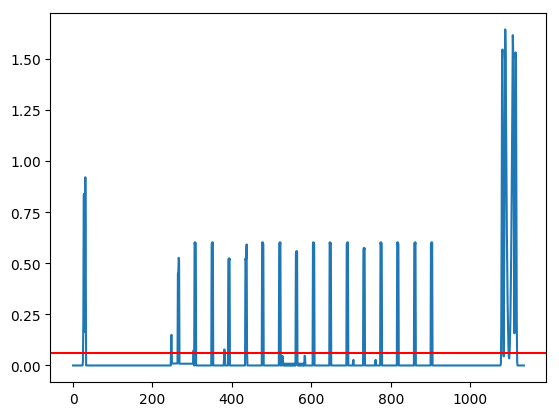

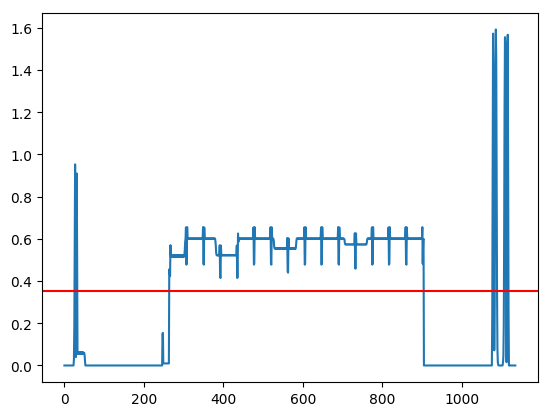

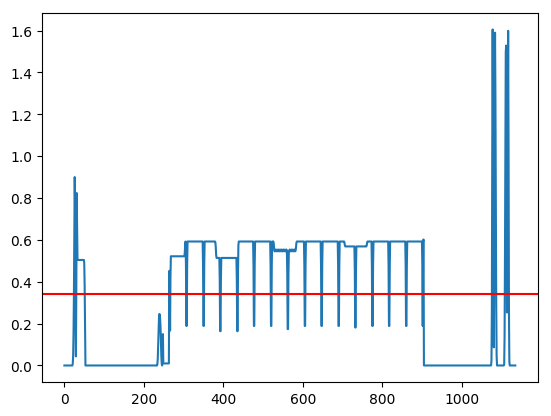

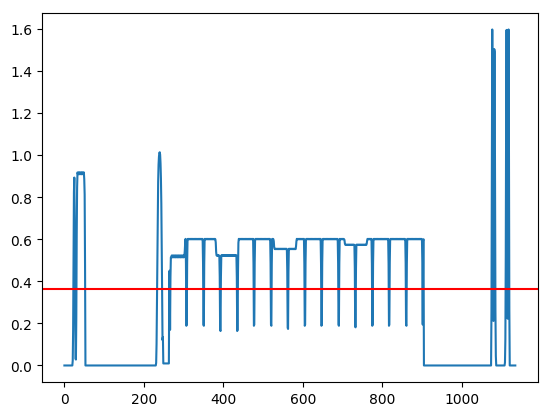

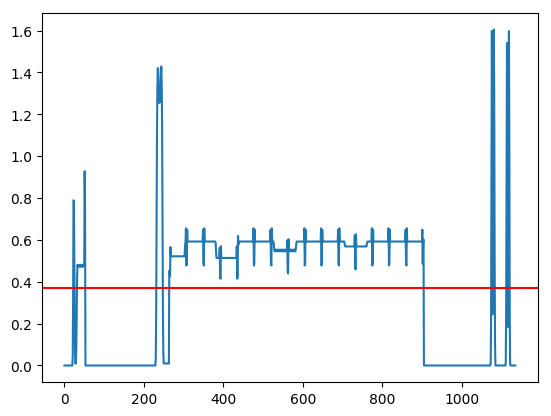

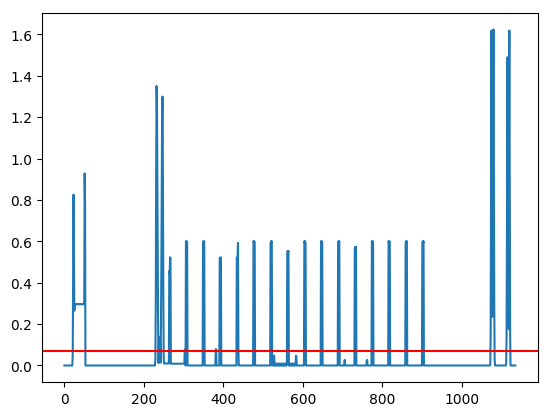

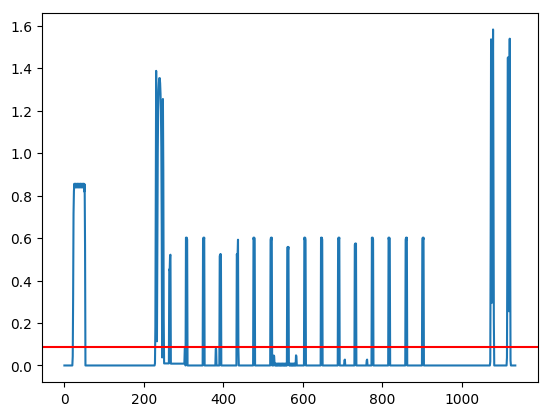

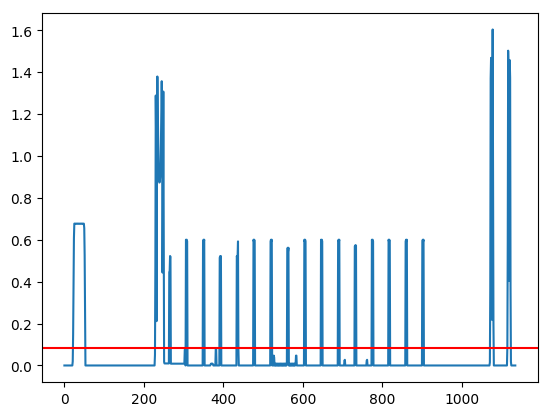

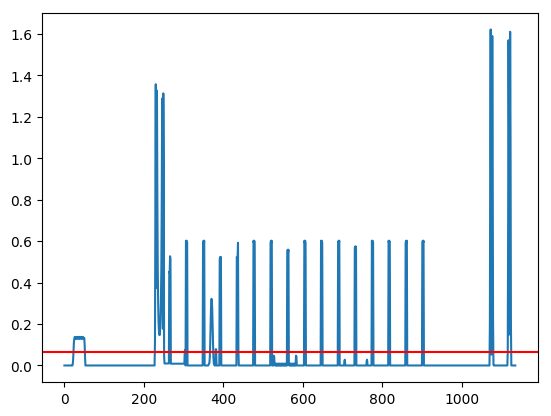

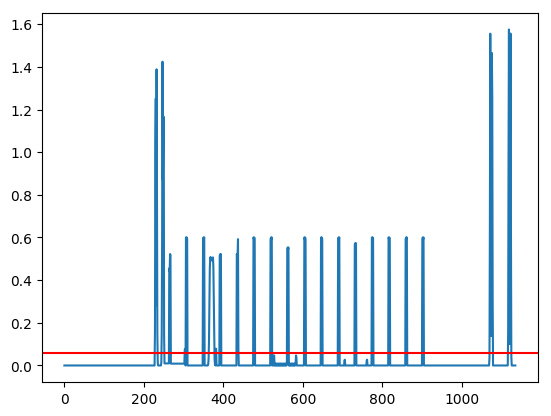

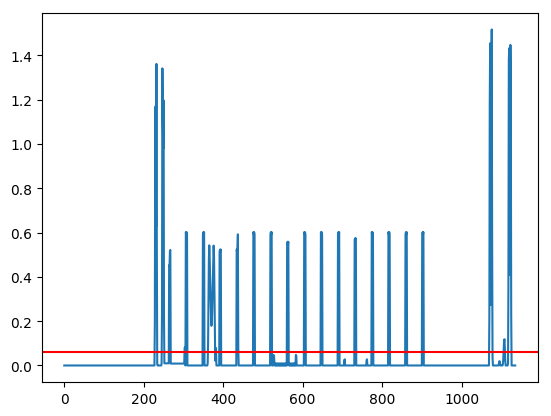

In [86]:
# when the examined column is a line
for i in k-7:k+7
    figure()
    plot(edges_mat[:,i])
    axhline(mean(edges_mat[:,i]), color="red")
    show()
end

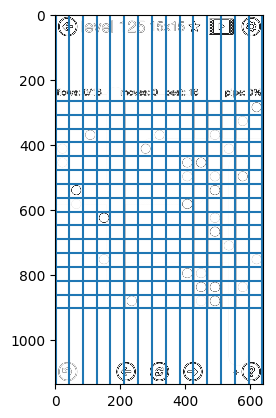

In [78]:
rows, cols = detect_board(img)
imshow(edges_mat,"Greys")
for i in rows
    axhline(i)
end
for i in cols
    axvline(i)
end

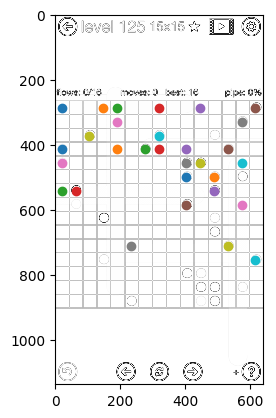

In [79]:
imshow(mag,"Greys")
agg = Set()
for x in 1:length(rows)-1
    for y in 1:length(cols)-1
        xco = floor(Int, (rows[x] + rows[x+1])/2)
        yco = floor(Int, (cols[y] + cols[y+1])/2)
        c = img[xco,yco]
        if !in(c,agg)
            push!(agg,c)
            scatter([yco],[xco])
        end
    end
end
agg = collect(agg)
convert(Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},1},agg)

In [80]:
filtered = [convert(XYZ,c) for c in agg if convert(HSV,c).v > 0.3]
print(length(filtered))
filtered

17

In [81]:
function colour_similar_test(c1, c2)
    return sqrt((c1.x - c2.x)^2 + (c1.y - c2.y)^2 + (c1.z - c2.z)^2)
end

for i in 1:17
    for j in i+1:17
        s = colour_similar_test(filtered[i], filtered[j])
        if s < 0.05
            println(i," ", j," ", s)
        end
    end
end

13 14 0.03168013


In [82]:
img = load("test3.png")
prob, colours = get_problem(img)

([0 0 … 0 1; 0 0 … 2 0; … ; 0 0 … 16 0; 0 0 … 0 0], Any[XYZ{Float32}(0.403689,0.453374,0.205315), XYZ{Float32}(0.123329,0.0587776,0.223103), XYZ{Float32}(0.492277,0.372315,0.0459409), XYZ{Float32}(0.412456,0.212673,0.0193339), XYZ{Float32}(0.0473199,0.0189279,0.249218), XYZ{Float32}(0.664659,0.800859,0.11957), XYZ{Float32}(0.357576,0.715152,0.119192), XYZ{Float32}(0.079821,0.159642,0.026607), XYZ{Float32}(0.468392,0.239049,0.301589), XYZ{Float32}(0.359437,0.379884,0.410289), XYZ{Float32}(0.16678,0.096796,0.0308757), XYZ{Float32}(0.121455,0.176296,0.24588), XYZ{Float32}(0.95047,1.0,1.08883), XYZ{Float32}(0.592894,0.284848,0.969638), XYZ{Float32}(0.538014,0.787327,1.0695), XYZ{Float32}(0.180438,0.072175,0.950304)], Any[265, 307, 350, 392, 435, 477, 520, 562, 605, 647, 690, 732, 775, 817, 860, 902], Any[2, 43, 85, 128, 170, 213, 255, 298, 340, 383, 425, 468, 510, 553, 595, 637])

In [83]:
detect_board(img)

(Any[265, 307, 350, 392, 435, 477, 520, 562, 605, 647, 690, 732, 775, 817, 860, 902], Any[2, 43, 85, 128, 170, 213, 255, 298, 340, 383, 425, 468, 510, 553, 595, 637])